# Vehicle Routing Problem


This program uses a genetic algorithm to solve the vehicle routing problem. The vehicle routing problem (VRP) is similar to the Travelling salesman (TSP) problem. The difference between the two is that the VRP problem has to optimize n paths, not just one. So solving the VRP for n = 1 is equivalent to the TSP.

Try it out!!! Just change the variable below to the number of vehicles you want to route around Berlin. Then scroll to the bottom of the page to see the map!

In [1]:
# Just modify this variable to change the number of vehicles!
# FYI the color pallete I am using only has 10 colors
# this means for any value over 9, more than one path will be plotted with the same color (one color is reserved for plotting the vehicle stops)
num_vehicles = 6

Import libraries needed for the program, set the plotting theme and read in the stops for the vehicles.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint, shuffle, choice
from deap import creator, base, tools, algorithms
from numpy.random import permutation
from numba import njit, jit

sns.set_theme()
df = pd.read_csv("Berlin Coordinates.csv")

Get the path for each vehicle from the genome

In [3]:
# the njit decorator is used to try to speed up the function by compiling it with numba
njit()
def split_n_path(genome: list, n_vehicles: int):
    start_index = 0
    sub_paths = []
    for i in range(len(genome)):
        # delimiters are used to serparate individual paths in the genome
        # there are num_vehicles - 1 delimeters in every genome
        # you might wonder why I don't use a single delimiting item
        # the answer is that I generate permuations with numpy and it is unhappy if there are duplicate items
        if genome[i] >= n_vehicles:
            sub_paths.append(genome[start_index:i])
            start_index = i + 1
    sub_paths.append(genome[start_index:])

    return sub_paths

Calculate the path length for an individual vehicle.

In [4]:
jit(nopython=False, parallel=True)
def get_path_length(path: list):
    if len(path) == 0:
        return 0.0
    path_length = 0
    # create two series so that at any index the row in the destination dataframe is the place that comes after the row at the same index in the departing_from dataframe
    departing_from = df.iloc[path[0:-1]].to_numpy()
    destination = df.iloc[path[1:]].to_numpy()
    # reset the index so it doesn't mess up the calculations
    #departing_from.reset_index(inplace=True, drop=True)
    #destination.reset_index(inplace=True, drop=True)
    # calculates delta x squared and delta y squared for every edge in the graph EXCEPT the edge between the last and first node
    location_deltas_squared = (departing_from - destination)**2
    # finish the distance calculation
    point_distances = np.sqrt(location_deltas_squared.sum(axis=1))
    #distances = np.sqrt(np.sum(location_deltas_squared, location_deltas_squared, axis=1))
    # add the distances between the points
    path_length += point_distances.sum()


    # get length from last node to first node
    first_node = df.iloc[[path[0]]]
    last_node = df.iloc[[path[-1]]]
    first_node.reset_index(inplace=True, drop=True)
    last_node.reset_index(inplace=True, drop=True)
    location_deltas_squared = (first_node - last_node)**2
    distances = np.sqrt(location_deltas_squared["X"] + location_deltas_squared["Y"])
    path_length += distances.sum()
    return path_length

Take the genome and figure out the length of the longest path a vehicle is assigned

In [5]:
njit(parallel=True)
def get_longest_path_length(path: list, num_locations: int):
    # Turn the genome into the vehicle paths
    sub_paths = split_n_path(path, num_locations)
    
    # find the longest vehicle path
    longest_path = 0
    for p in sub_paths:
        longest_path = max(longest_path, get_path_length(p))

    return (longest_path, )

This function plots and individual vehicles path

In [6]:
def plot_path(path: list, color: int):
    if len(path) == 0:
        return
    values = df.iloc[path]
    x_values = values["X"]
    y_values = values["Y"]
    plt.plot(x_values, y_values, color=sns.color_palette()[color])
    first_and_last = df.iloc[[path[0], path[-1]]]
    x_values = first_and_last["X"]
    y_values = first_and_last["Y"]
    plt.plot(x_values, y_values, color=sns.color_palette()[color])

This function plots a genome by splitting it into individual vehicle paths and plotting them one by one.

In [7]:
def plot_n_paths(path: list, num_locations: int):
    sub_paths = split_n_path(path, num_locations)
    df.plot(kind="scatter", x="X", y="Y")
    color = 1
    for p in sub_paths:
        plot_path(p, color)
        color += 1
        if color >= 10:
            color = 1
        
    plt.show()

These are the settings for the genetic algorithm. Feel free to play around with them!

In [8]:
population_size = 250
p_crossover = 0.6
p_mutation = 0.3
max_generations = 500
hall_of_fame_size = int(population_size*0.05)

These are also settings for the genetic algorthm. These shouldn't be changed manually.

In [9]:
num_locations = df.shape[0]
genome_length = num_locations + (num_vehicles - 1)

This is a custom selection function. It is used to decide which individuals from the current generation get to go onto the next generation. I can't find anywhere DEAP provides the elitism strategy. Therefore, I implemented elitism by mixing the top performing individuals in with the others.

In [10]:
def my_select(individuals, k, tournsize, hof_in, fit_attr: str = "fitness"):
    selected_individuals = tools.selTournament(individuals=individuals, k=len(individuals)-hall_of_fame_size, tournsize=tournsize)
    selected_individuals += hof_in
    shuffle(selected_individuals)
    return selected_individuals

This is a custom mutation function. I wanted to keep the basic idea of shuffling index, but I wanted to the the probability so some generations things get shaken up more than others. I hoped this would increase diversity in the population while not turning it into just a random search.

In [11]:
def my_mutate(individual, indpb):
    prob = choice([1.0/54.0, 2.0/54.0, 3.0/54.0])
    return tools.mutShuffleIndexes(individual, prob)

This is used to store the greatest individuals who existed in the runtime of the program.

In [12]:
hof = tools.HallOfFame(hall_of_fame_size)

Register the functions needed by the genetic algorithm

In [13]:
# create the toolbox class and register the functions needed in the toolbox
toolbox = base.Toolbox()
toolbox.register("evaluate", get_longest_path_length, num_locations=num_locations)
toolbox.register("select", my_select, tournsize=3, hof_in=hof)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", my_mutate, indpb=0/54.0)


# create the statistics object and register the necessary functions
stats = tools.Statistics(lambda individual: individual.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)


# create the fitness strategy, this is different than the fitness function, the fitness strategy can contain multiple fitness functions
creator.create("fitness_min", base.Fitness, weights=(-1.0,))
# class used to represent individuals, individuals are represented as lists and use the fitness_min class to measure fitness
creator.create("Individual", list, fitness=creator.fitness_min)

In case you are wondering why I use lists for the genomes instead of numpy's ndarray, it is because DEAP doesn't play nicely with numpy arrays :(

A genome is made up of integers represents vehicle stops and delimeters to seperate the vehicle paths. There are num_vehicles - 1 delimeters in every genome. You may wonder why I don't use a single delimiting item. The answer is that I generate permuations with numpy and it is unhappy if there are duplicate items

In [14]:
num_delimiters = num_vehicles - 1
genome_example = list(range(num_locations + num_delimiters))
population = [creator.Individual(list(permutation(genome_example))) for _ in range(population_size)]

Run the genetic algorithm and output the length of the longest vehicle route.

In [15]:
population, log_book = algorithms.eaSimple(population=population, toolbox=toolbox, cxpb=p_crossover, mutpb=p_mutation, ngen=max_generations, stats=stats, verbose=False, halloffame=hof)
min_fitness_values, mean_fitness_values = log_book.select("min", "avg")
# the first index represent the individual in the hall of fame
print(get_longest_path_length(hof[0], num_locations))



(2612.3234573402697,)


Finally, make a nice visualization of the vehicle paths found!

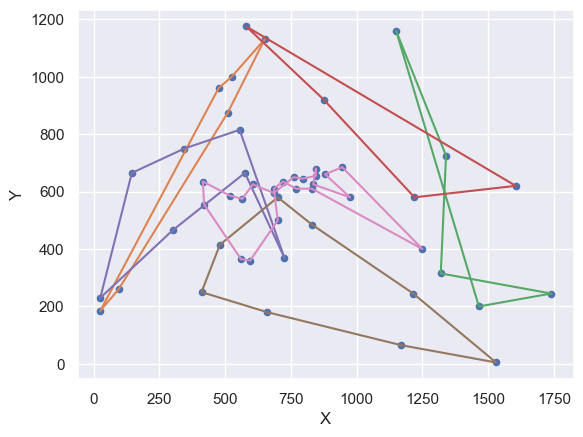

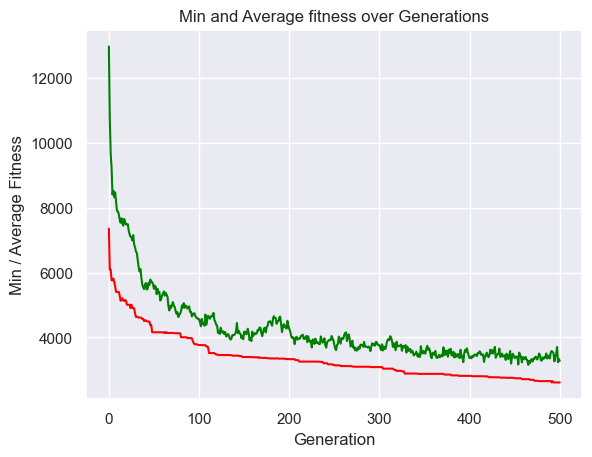

In [16]:
plot_n_paths(hof[0], num_locations)
plt.plot(min_fitness_values, color="red")
plt.plot(mean_fitness_values, color="green")
plt.xlabel("Generation")
plt.ylabel("Min / Average Fitness")
plt.title("Min and Average fitness over Generations")
plt.show()